In [1]:
# Cell 0
# Install libraries
# - transformers/datasets accelerate => for BERT + Trainer API (Hugging Face)
# - scikit-learn => for Logistic Regression baseline
# - matplotlib/seaborn => for plots
!pip -q install transformers datasets accelerate torch --upgrade
!pip -q install scikit-learn matplotlib seaborn tqdm


In [2]:
# Cell 1
# Imports and global config
import os, math, random, time
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

# Make plots look nice
sns.set(style="whitegrid")

# Reproducibility
RANDOM_SEED = 6905
def set_seed(seed=RANDOM_SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(RANDOM_SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


/Users/swethasaseendran/Documents/UMass/690F Security in AI/Assignment/EduPilot_690F/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [8]:
# Cell 2
# Loading the dataset

df = pd.read_csv("../data/EduPilot_dataset_2000.csv")

# Sanity checks
print("Columns:", list(df.columns))
print("Rows:", len(df))
print(df.head(5))

# Required columns check (will raise if missing)
required = {"text", "interview_round"}
missing = required - set(df.columns)
assert not missing, f"Missing required columns: {missing}"
label_words = ["OA", "Technical", "System Design", "Behavioral/HR", "ML Case Study"]

# check for presence of label_words in "text"
def contains_label(text):
    for w in label_words:
        if w in str(text):
            return True
    return False

mask = df["text"].apply(contains_label)
df.loc[mask, ["id", "text", "interview_round"]].head(10)

Columns: ['id', 'user_query', 'job_role', 'company', 'location', 'interview_round', 'mock_question', 'text']
Rows: 2000
   id                                         user_query          job_role  \
0   1  What should I study for a Data Scientist posit...    Data Scientist   
1   2  I have an interview for SRE at Salesforce in L...               SRE   
2   3  I have an interview for Product Manager at Pin...   Product Manager   
3   4  Help me practice for Backend Engineer intervie...  Backend Engineer   
4   5  Give me common interview problems for Backend ...  Backend Engineer   

      company   location interview_round  \
0        Uber    Toronto              OA   
1  Salesforce     London              OA   
2   Pinterest    Seattle              OA   
3     Dropbox  Hyderabad              OA   
4       Apple     Munich              OA   

                                       mock_question  \
0    Count islands in a binary matrix using DFS/BFS.   
1  Given a string, return length o

,id,text,interview_round


In [9]:
# Using 'mock_question' resulted in 1.0 accuracy
# Building a leak-safe text field that excludes both label words and `mock_question`
label_words = ["OA", "Technical", "System Design", "Behavioral/HR", "ML Case Study"]

def strip_labels(text, labels):
    t = str(text)
    for w in labels:
        t = t.replace(w, "")
    return " ".join(t.split())

def make_text_safe(row):
    # DO NOT include mock_question here – it's round-specific
    parts = [
        strip_labels(row["user_query"], label_words),
        str(row["job_role"]),
        str(row["company"]),
        str(row["location"]),
    ]
    return " ||| ".join([p for p in parts if p])

df["text_safe"] = df.apply(make_text_safe, axis=1)

# Sanity: ensure no label words remain
assert not df["text_safe"].str.contains("|".join(label_words), case=False, na=False).any()

Classes: ['Behavioral/HR', 'ML Case Study', 'OA', 'System Design', 'Technical']
Training on 1400 samples; validating on 600 samples...
Epoch 01: train loss 1.6098 acc 0.191 | test loss 1.6096 acc 0.188
Epoch 02: train loss 1.5975 acc 0.415 | test loss 1.6093 acc 0.200
Epoch 04: train loss 1.5592 acc 0.585 | test loss 1.6100 acc 0.215
Epoch 06: train loss 1.4790 acc 0.621 | test loss 1.6174 acc 0.212
Epoch 08: train loss 1.3559 acc 0.669 | test loss 1.6374 acc 0.215
Epoch 10: train loss 1.2078 acc 0.714 | test loss 1.6769 acc 0.200
Epoch 12: train loss 1.0559 acc 0.771 | test loss 1.7329 acc 0.202
Epoch 14: train loss 0.9110 acc 0.811 | test loss 1.7992 acc 0.203
Epoch 16: train loss 0.7821 acc 0.846 | test loss 1.8745 acc 0.208
Epoch 18: train loss 0.6731 acc 0.876 | test loss 1.9591 acc 0.203

MLP — Test accuracy: 0.2033
MLP — Test log-loss : 1.9591
Mean losses — train: 0.6291 | test: 1.9591

[Threshold MIA] ROC-AUC (MLP): 0.9322
TPR@FPR<=0.100 (MLP): 0.7686
TPR@FPR<=0.010 (MLP): 0.31

/Users/swethasaseendran/Documents/UMass/690F Security in AI/Assignment/EduPilot_690F/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


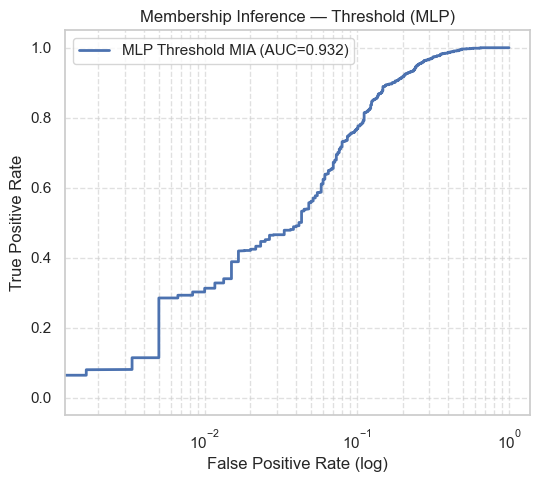

In [10]:
# ============================================================
# TF-IDF  →  2-layer MLP (PyTorch)  →  MIA (threshold)
# ============================================================
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -------------------------
# 0) Config
# -------------------------
RANDOM_SEED = 6905
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

TEXT_COL = "text_safe" if "text_safe" in df.columns else "text"  # prefer leak-safe text
LABEL_COL = "interview_round"
TEST_SIZE = 0.30

# Vectorizer params (high capacity → mild overfitting → stronger MIA)
NGRAMS = (1,3)
MAX_FEATS = 40_000

# MLP params (intentionally a bit over-parameterized)
HID = 512
EPOCHS = 18
BATCH = 64
LR = 3e-4
WEIGHT_DECAY = 0.0  # keep 0 to allow some overfitting

# Optional LiRA (shadow models)
ENABLE_LIRA = False
SHADOWS = 64           # we can increase it to 128 or 256
SAMPLE_FRAC = 0.6      # <= 0.6 gives more diversity (helps LiRA)
SHADOW_EPOCHS = 8      # keeping it small so it finishes

# -------------------------
# 1) Split + labels
# -------------------------
train_df, test_df = train_test_split(
    df, test_size=TEST_SIZE, stratify=df[LABEL_COL], random_state=RANDOM_SEED
)

le = LabelEncoder()
y_train = le.fit_transform(train_df[LABEL_COL])
y_test  = le.transform(test_df[LABEL_COL])
num_labels = len(le.classes_)
print("Classes:", list(le.classes_))

# -------------------------
# 2) TF-IDF features
# -------------------------
tfidf = TfidfVectorizer(ngram_range=NGRAMS, max_features=MAX_FEATS)
X_train = tfidf.fit_transform(train_df[TEXT_COL])
X_test  = tfidf.transform(test_df[TEXT_COL])

# Helper dataset that reads from a CSR matrix without densifying the whole thing
class CSRDataset(Dataset):
    def __init__(self, X_csr, y):
        self.X = X_csr
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        # convert this row to a dense float32 vector on the fly
        x = torch.tensor(self.X[idx].toarray()[0], dtype=torch.float32)
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y

train_ds = CSRDataset(X_train, y_train)
test_ds  = CSRDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)

# -------------------------
# 3) Defineing 2-layer MLP
# -------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hid, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # logits

mlp = MLP(in_dim=X_train.shape[1], hid=HID, out_dim=num_labels).to(device)
opt = torch.optim.Adam(mlp.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

# -------------------------
# 4) Train
# -------------------------
def run_epoch(loader, train=True):
    model = mlp
    if train: model.train()
    else:     model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()
            total_loss += float(loss.item()) * xb.size(0)
            total_correct += int((logits.argmax(-1) == yb).sum().item())
            total_n += xb.size(0)
    return total_loss/total_n, total_correct/total_n

print(f"Training on {len(train_ds)} samples; validating on {len(test_ds)} samples...")
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    te_loss, te_acc = run_epoch(test_loader,  train=False)
    if ep % 2 == 0 or ep == 1:
        print(f"Epoch {ep:02d}: train loss {tr_loss:.4f} acc {tr_acc:.3f} | test loss {te_loss:.4f} acc {te_acc:.3f}")

# -------------------------
# 5) Final evaluation + per-example losses
# -------------------------
@torch.no_grad()
def collect_losses(loader):
    model = mlp
    model.eval()
    losses, probs, labels = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        lp = F.log_softmax(logits, dim=-1)
        chosen = lp[torch.arange(lp.size(0)), yb]  # log prob of the true class
        losses.extend((-chosen).cpu().numpy().tolist())
        probs.extend(torch.softmax(logits, dim=-1).cpu().numpy().tolist())
        labels.extend(yb.cpu().numpy().tolist())
    return np.array(losses), np.array(probs), np.array(labels)

train_losses_mlp, train_probs_mlp, train_y_true = collect_losses(train_loader)
test_losses_mlp,  test_probs_mlp,  test_y_true  = collect_losses(test_loader)

# Accuracy and log-loss on test
test_pred_mlp = test_probs_mlp.argmax(axis=1)
acc_mlp = accuracy_score(test_y_true, test_pred_mlp)
ll_mlp  = log_loss(test_y_true, test_probs_mlp)
print(f"\nMLP — Test accuracy: {acc_mlp:.4f}")
print(f"MLP — Test log-loss : {ll_mlp:.4f}")
print(f"Mean losses — train: {train_losses_mlp.mean():.4f} | test: {test_losses_mlp.mean():.4f}")

# -------------------------
# 6) Simple Threshold MIA (Shokri-style): ROC/AUC + TPR@low-FPR
# -------------------------
scores_mia = np.concatenate([-train_losses_mlp, -test_losses_mlp])  # higher => more member-like
is_member   = np.concatenate([np.ones_like(train_losses_mlp), np.zeros_like(test_losses_mlp)])

fpr_mia, tpr_mia, _ = roc_curve(is_member, scores_mia)
auc_mia = auc(fpr_mia, tpr_mia)
print(f"\n[Threshold MIA] ROC-AUC (MLP): {auc_mia:.4f}")

def tpr_at_fpr(fpr, tpr, target):
    idx = np.where(fpr <= target)[0]
    return float(tpr[idx].max()) if idx.size > 0 else 0.0

for target in [0.1, 0.01, 0.001]:
    print(f"TPR@FPR<={target:.3f} (MLP): {tpr_at_fpr(fpr_mia, tpr_mia, target):.4f}")

plt.figure(figsize=(6,5))
plt.plot(fpr_mia, tpr_mia, label=f"MLP Threshold MIA (AUC={auc_mia:.3f})", lw=2)
plt.xscale("log"); plt.xlabel("False Positive Rate (log)"); plt.ylabel("True Positive Rate")
plt.title("Membership Inference — Threshold (MLP)")
plt.grid(True, which="both", ls="--", alpha=0.6); plt.legend(); plt.show()




Epoch 01: train acc 0.891 | test acc 0.200
Epoch 02: train acc 0.898 | test acc 0.200
Epoch 04: train acc 0.915 | test acc 0.205
Epoch 06: train acc 0.931 | test acc 0.202
Epoch 08: train acc 0.937 | test acc 0.197
Epoch 10: train acc 0.946 | test acc 0.202
Epoch 12: train acc 0.950 | test acc 0.200
Epoch 14: train acc 0.960 | test acc 0.197
Epoch 16: train acc 0.960 | test acc 0.195
Epoch 18: train acc 0.962 | test acc 0.190


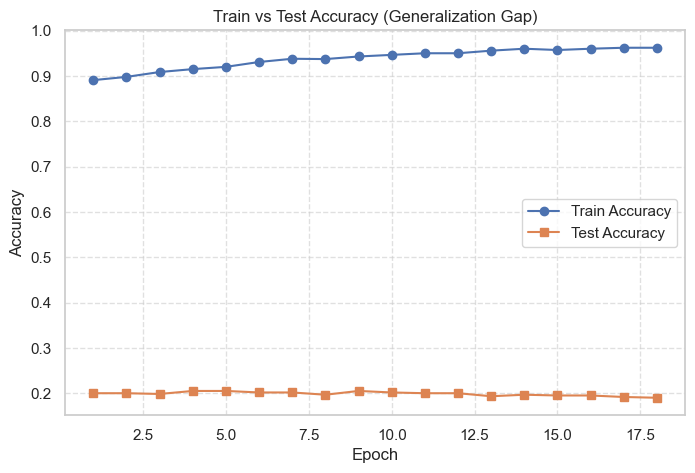

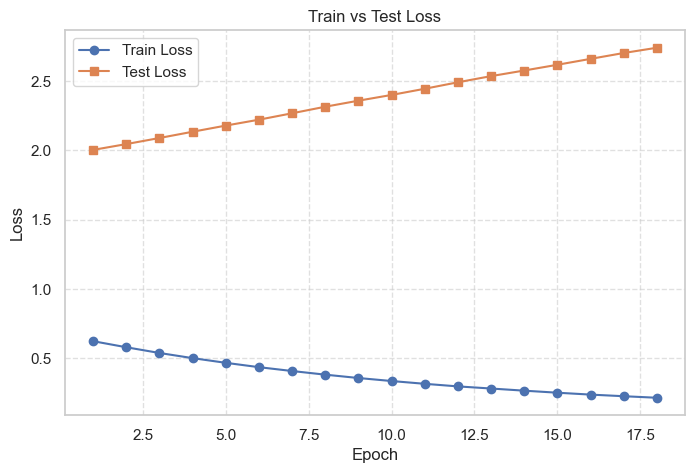

In [11]:
import matplotlib.pyplot as plt

# Track train/test metrics during training
train_acc_hist, test_acc_hist = [], []
train_loss_hist, test_loss_hist = [], []

def run_epoch(loader, train=True):
    model = mlp
    if train: model.train()
    else:     model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()
            total_loss += float(loss.item()) * xb.size(0)
            total_correct += int((logits.argmax(-1) == yb).sum().item())
            total_n += xb.size(0)
    return total_loss/total_n, total_correct/total_n

# Training with history logging
EPOCHS = 18
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    te_loss, te_acc = run_epoch(test_loader, train=False)

    train_loss_hist.append(tr_loss)
    train_acc_hist.append(tr_acc)
    test_loss_hist.append(te_loss)
    test_acc_hist.append(te_acc)

    if ep % 2 == 0 or ep == 1:
        print(f"Epoch {ep:02d}: train acc {tr_acc:.3f} | test acc {te_acc:.3f}")

# --- Plot accuracy gap ---
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_acc_hist, label="Train Accuracy", marker="o")
plt.plot(range(1, EPOCHS+1), test_acc_hist, label="Test Accuracy", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (Generalization Gap)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --- Plot loss gap ---
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_loss_hist, label="Train Loss", marker="o")
plt.plot(range(1, EPOCHS+1), test_loss_hist, label="Test Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


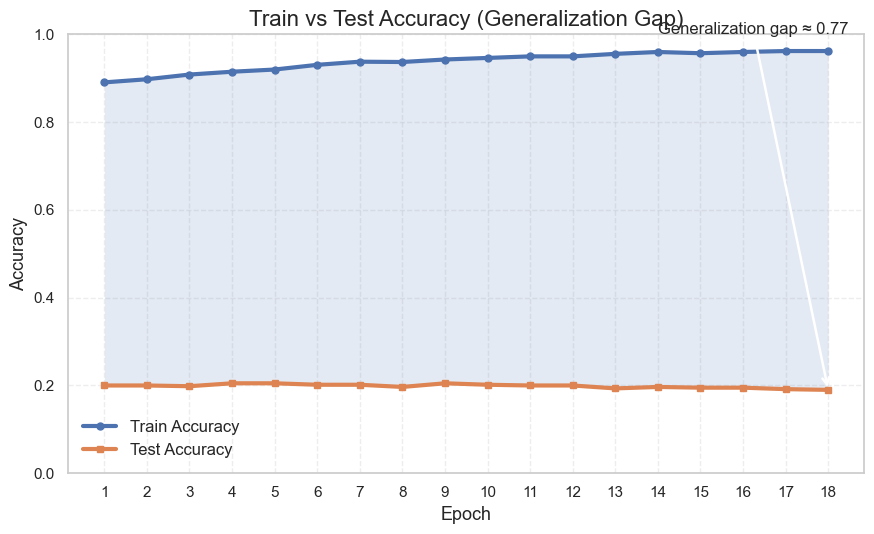

In [12]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(train_acc_hist)+1)

plt.figure(figsize=(9,5.5))
plt.plot(epochs, train_acc_hist, linewidth=3, marker="o", markersize=5, label="Train Accuracy")
plt.plot(epochs, test_acc_hist,  linewidth=3, marker="s", markersize=5, label="Test Accuracy")

# shaded gap
upper = np.maximum(train_acc_hist, test_acc_hist)
lower = np.minimum(train_acc_hist, test_acc_hist)
plt.fill_between(epochs, lower, upper, alpha=0.15)

# annotate last-epoch gap
gap = train_acc_hist[-1] - test_acc_hist[-1]
plt.annotate(f"Generalization gap ≈ {gap:.2f}",
             xy=(epochs[-1], test_acc_hist[-1]),
             xytext=(epochs[-1]-4, min(1.0, train_acc_hist[-1]+0.05)),
             arrowprops=dict(arrowstyle="->", lw=1.8), fontsize=12)

plt.title("Train vs Test Accuracy (Generalization Gap)", fontsize=16)
plt.xlabel("Epoch", fontsize=13); plt.ylabel("Accuracy", fontsize=13)
plt.xticks(epochs)
plt.ylim(0, 1.0)
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("gap_accuracy.png", dpi=200, bbox_inches="tight", transparent=True)
plt.show()


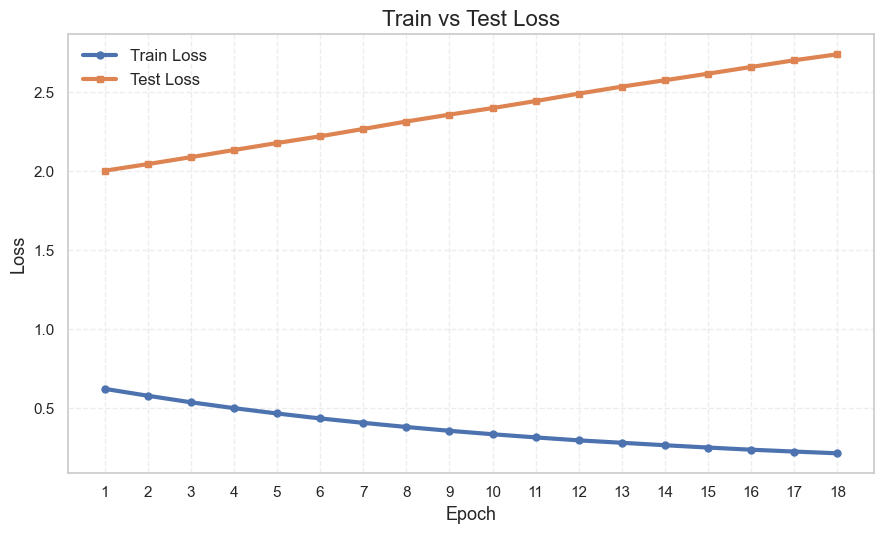

In [13]:
plt.figure(figsize=(9,5.5))
plt.plot(epochs, train_loss_hist, linewidth=3, marker="o", markersize=5, label="Train Loss")
plt.plot(epochs, test_loss_hist,  linewidth=3, marker="s", markersize=5, label="Test Loss")

plt.title("Train vs Test Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=13); plt.ylabel("Loss", fontsize=13)
plt.xticks(epochs)
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("gap_loss.png", dpi=200, bbox_inches="tight", transparent=True)
plt.show()


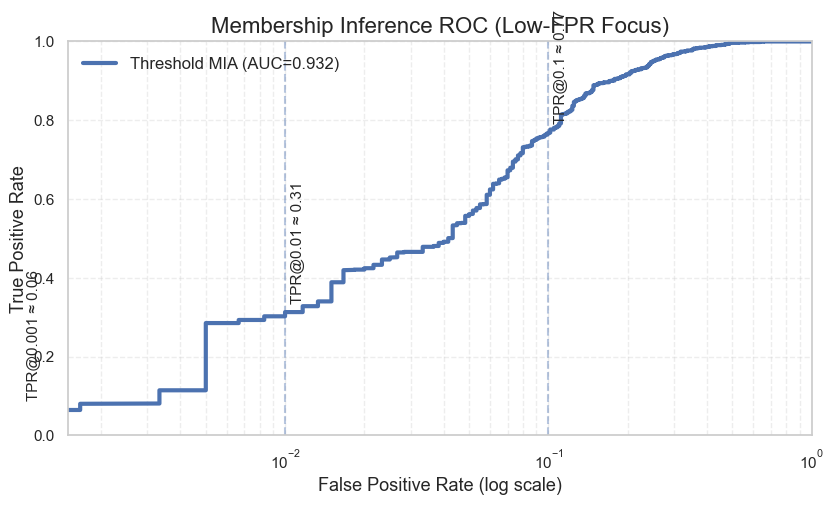

In [15]:
plt.figure(figsize=(8.5,5.2))
plt.plot(fpr_mia, tpr_mia, linewidth=3, label=f"Threshold MIA (AUC={auc_mia:.3f})")

# vertical markers at the LiRA-relevant low-FPR regimes
for x in [1e-1, 1e-2, 1e-3]:
    plt.axvline(x, linestyle="--", alpha=0.4)
    tpr_val = tpr_at_fpr(fpr_mia, tpr_mia, x)
    plt.text(x*1.05, min(0.98, tpr_val+0.03), f"TPR@{x:g} ≈ {tpr_val:.2f}", rotation=90, fontsize=11)

plt.xscale("log")
plt.xlim(min(fpr_mia[fpr_mia>0])*0.9, 1.0)
plt.ylim(0.0, 1.0)
plt.title("Membership Inference ROC (Low-FPR Focus)", fontsize=16)
plt.xlabel("False Positive Rate (log scale)", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.grid(True, which="both", linestyle="--", alpha=0.35)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("roc_low_fpr.png", dpi=220, bbox_inches="tight", transparent=True)
plt.show()


# LiRA Attack on MLP

In [37]:
import torch.nn as nn
import torch.nn.functional as F

# LiRA/Shadow config (reuse params from above)
SHADOWS = 50
SAMPLE_FRAC = 0.5
SHADOW_EPOCHS = 3

def train_shadow(X, y, in_dim, hid, out_dim, epochs=SHADOW_EPOCHS, batch=64):
    ds = CSRDataset(X, y)
    loader = DataLoader(ds, batch_size=batch, shuffle=True, drop_last=False)
    model = MLP(in_dim=in_dim, hid=hid, out_dim=out_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        model.train()
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
    return model

@torch.no_grad()
def get_losses(model, loader):
    model.eval()
    losses = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        lp = F.log_softmax(logits, dim=-1)
        chosen = lp[torch.arange(lp.size(0)), yb]
        losses.extend((-chosen).cpu().numpy().tolist())
    return np.array(losses)

In [38]:
import numpy as np

# Run SHADOWS shadow models for LiRA
shadow_train_losses = []
shadow_test_losses = []

for i in range(SHADOWS):
    # Random split for shadow model
    idx = np.random.permutation(len(df))
    split = int(SAMPLE_FRAC * len(df))
    shadow_idx_train = idx[:split]
    shadow_idx_test = idx[split:split + len(test_ds)]

    X_shadow_train = tfidf.transform(df.iloc[shadow_idx_train]["text_safe"])
    y_shadow_train = y_train[shadow_idx_train % len(y_train)]
    X_shadow_test = tfidf.transform(df.iloc[shadow_idx_test]["text_safe"])
    y_shadow_test = y_test[shadow_idx_test % len(y_test)]

    shadow_model = train_shadow(
        X_shadow_train, y_shadow_train,
        in_dim=X_shadow_train.shape[1], hid=HID, out_dim=len(np.unique(y_train)),
        epochs=SHADOW_EPOCHS, batch=BATCH
    )

    train_loader_shadow = torch.utils.data.DataLoader(
        CSRDataset(X_shadow_train, y_shadow_train), batch_size=BATCH, shuffle=False
    )
    test_loader_shadow = torch.utils.data.DataLoader(
        CSRDataset(X_shadow_test, y_shadow_test), batch_size=BATCH, shuffle=False
    )

    train_losses = get_losses(shadow_model, train_loader_shadow)
    test_losses = get_losses(shadow_model, test_loader_shadow)

    shadow_train_losses.append(train_losses)
    shadow_test_losses.append(test_losses)

# Convert to arrays
shadow_train_losses = np.array(shadow_train_losses)
shadow_test_losses = np.array(shadow_test_losses)

# LiRA stats
print(f"LiRA shadow models run: {SHADOWS}")
print(f"Train losses shape: {shadow_train_losses.shape}")
print(f"Test losses shape: {shadow_test_losses.shape}")
print(f"Mean train loss (LiRA): {shadow_train_losses.mean():.4f}")
print(f"Mean test loss (LiRA): {shadow_test_losses.mean():.4f}")

LiRA shadow models run: 50
Train losses shape: (50, 1000)
Test losses shape: (50, 600)
Mean train loss (LiRA): 1.5713
Mean test loss (LiRA): 1.6102


LiRA ROC-AUC: 0.9322


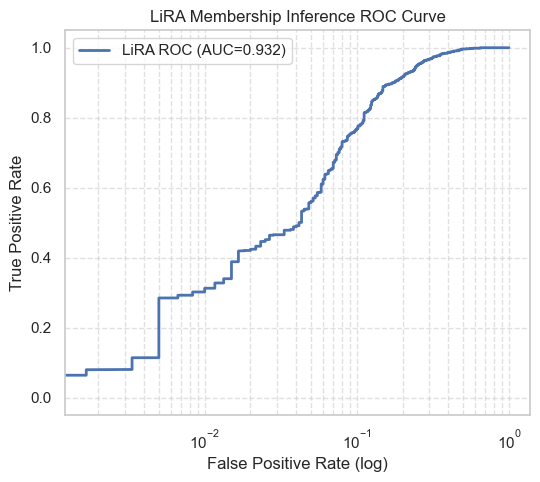

In [39]:
# LiRA ROC Curve using KDE likelihood ratios
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np

# Flatten shadow losses for KDE
train_losses_flat = shadow_train_losses.flatten()
test_losses_flat = shadow_test_losses.flatten()

# Fit KDEs to train/test shadow losses
kde_train = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(train_losses_flat[:, None])
kde_test = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(test_losses_flat[:, None])

# Get losses for target model's train/test samples
target_train_losses = train_losses_mlp
target_test_losses = test_losses_mlp

# Compute likelihood ratios for all samples
all_losses = np.concatenate([target_train_losses, target_test_losses])
is_member = np.concatenate([np.ones_like(target_train_losses), np.zeros_like(target_test_losses)])

log_p_train = kde_train.score_samples(all_losses[:, None])
log_p_test = kde_test.score_samples(all_losses[:, None])
likelihood_ratios = np.exp(log_p_train - log_p_test)

# ROC curve for LiRA
fpr_lira, tpr_lira, _ = roc_curve(is_member, likelihood_ratios)
auc_lira = auc(fpr_lira, tpr_lira)
print(f"LiRA ROC-AUC: {auc_lira:.4f}")

plt.figure(figsize=(6,5))
plt.plot(fpr_lira, tpr_lira, label=f"LiRA ROC (AUC={auc_lira:.3f})", lw=2)
plt.xscale("log")
plt.xlabel("False Positive Rate (log)")
plt.ylabel("True Positive Rate")
plt.title("LiRA Membership Inference ROC Curve")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()

In [40]:
# Print ROC-AUC values for both attacks
print(f"Threshold MIA ROC-AUC: {auc_mia:.10f}")
try:
    print(f"LiRA ROC-AUC: {auc_lira:.10f}")
except NameError:
    print("LiRA ROC-AUC not computed yet. Run the LiRA ROC cell above.")

Threshold MIA ROC-AUC: 0.9321755952
LiRA ROC-AUC: 0.9321755952


In [ ]:
# Diagnostic: Print and compare sample indices for target and shadow splits
print('Target train indices:', train_df.index[:10])
print('Target test indices:', test_df.index[:10])
try:
    print('Example shadow train indices (first shadow):', shadow_idx_train[:10])
    print('Example shadow test indices (first shadow):', shadow_idx_test[:10])
    overlap_train = set(train_df.index) & set(shadow_idx_train)
    overlap_test = set(test_df.index) & set(shadow_idx_test)
    print(f'Overlap between target train and shadow train: {len(overlap_train)}')
    print(f'Overlap between target test and shadow test: {len(overlap_test)}')
except Exception as e:
    print('Shadow indices not available in this scope. Run inside shadow model loop for full details.')